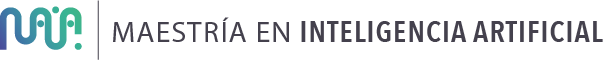

#### **IA Biomédica:** Laboratorio PharmaNet: Modelo, entrenamiento e inferencia 


> ##### Descubrimiento de Farmacos


> **Instructores**

*  Julio Castellanos


## 📝 Práctica: Análisis y Comprensión de PharmaNet

Esta práctica se enfoca en revisar dos scripts fundamentales:

- El código de entrenamiento, donde se definen las rutinas para cargar datos, entrenar y evaluar el modelo con métricas como Accuracy, NAP y AUC.
- El código de inferencia, que demuestra cómo aplicar el modelo para obtener predicciones con moléculas de test.

La meta principal es entender paso a paso cómo funciona PharmaNet al transformar SMILES en tensores, procesarlos mediante su arquitectura (Conv + RNN) y generar probabilidades de afinidad para cada target.

### PharmaNet Tutorial: Entrenamiento e Inferencia

Este *Notebook* ilustra los pasos fundamentales para:
1. Entrenar el modelo **PharmaNet** usando datos de SMILES.
2. Realizar  inferencia sobre un conjunto de prueba.


## 1. Imports Principales para Entrenamiento

In [1]:
# ## 1. Importaciones Principales

from __future__ import division, print_function

import copy
import os
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from tqdm import tqdm

# Modulos propios (asegúrate de tener estas rutas en tu proyecto)
from data.data_loader import SMILESDataset
from utils.metrics import pltauc, norm_ap_optimized
from models.Model import Model


print("PyTorch Version: ", torch.__version__)

/Users/juliocesar/miniforge3/envs/PharmaNet/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch Version:  1.9.0.post2


## 2. Configuración de Parámetros y Semilla

En esta sección, definimos los parámetros necesarios para la ejecución:
- GPU o CPU
- Fijación de semilla aleatoria para reproducibilidad

In [2]:
# 2. Configuración de Parámetros y Semilla

seed = 6766

torch.manual_seed(seed)
np.random.seed(seed)

# Configurar GPU (si está disponible)
ngpu = 1
os.environ['CUDA_VISIBLE_DEVICES'] = '{}'.format(ngpu)
device = torch.device("cuda" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

if device == 'cuda':
    torch.cuda.manual_seed(seed)

print("Dispositivo seleccionado:", device)

Dispositivo seleccionado: cpu


## 3. Lectura de Datos y Cross-Validation

Aquí cargamos archivos CSV con SMILES (por ejemplo, `Smiles_1.csv`, `Smiles_2.csv`, etc.) y seleccionamos la parte de entrenamiento y prueba según un índice de `cross_val`.

In [3]:
# 3. Lectura de Datos
train_path = "data/datasets/DUDE/"
A = pd.read_csv(train_path + 'Smiles_1.csv')
B = pd.read_csv(train_path + 'Smiles_2.csv')
C = pd.read_csv(train_path + 'Smiles_3.csv')
D = pd.read_csv(train_path + 'Smiles_4.csv')

cross_val = 1

if cross_val == 1:
    data_train = pd.concat([A, B, C], ignore_index=True)
    data_test = D
elif cross_val == 2:
    data_train = pd.concat([A, C, D], ignore_index=True)
    data_test = B
elif cross_val == 3:
    data_train = pd.concat([A, B, D], ignore_index=True)
    data_test = C
else:
    data_train = pd.concat([B, C, D], ignore_index=True)
    data_test = A

print('Data for train:', len(data_train['Smiles']))
print('Data for test :', len(data_test['Smiles']))

Data for train: 15321
Data for test : 5259


In [4]:
data_train

,Smiles,Target,Label
0,NC[C@H](Cc1cccc(F)c1)NC(=O)c4cc(Br)c(c2ccnc3[n...,akt1,0
1,Cc4n[nH]c5ccc(c3cncc(OC[C@@H](N)Cc1c[nH]c2cccc...,akt1,0
2,N[C@H](COc4cncc(c3ccc2NC(=O)C(c1ccco1)c2c3)c4)...,akt1,0
3,CC(C)(Cc1ccco1)C5C(=O)Nc6ccc(c4cncc(OC[C@@H](N...,akt1,0
4,CCn3c(c1nonc1N)nc4c(C#CC(C)(C)O)nc(O[C@@H](CCN...,akt1,0
...,...,...,...
15316,COc1ccc(F)cc1C(C)(C)CC(O)(Cc2cc(C)cc(C)c2)C(F)...,mcr,101
15317,OC(=O)c5ccc4C3=NN(c1ccc(C#N)c(Cl)c1)[C@H](c2cc...,mcr,101
15318,COc1ccc(F)cc1C(C)(C)CC(O)(Cc2cc(C)cc(C)c2C#N)C...,mcr,101
15319,COc4c(O)ccc5o\c(=C/c1cccc(O)c1)c3C2C(NC(C)(C)C...,mcr,101


In [5]:
data_test

,Smiles,Target,Label
0,C/C(c1ccc[nH]1)=c2/c(=O)[nH]c3ccc(NC(N)=O)cc23,akt1,0
1,Cc3n[nH]c4cn(=O)c(c2cncc(OC[C@@H](N)Cc1ccccc1)...,akt1,0
2,C5CN(Cc4ccc(c2nc1ncccc1cc2c3ccccc3)cc4)CCC5c7c...,akt1,0
3,N[C@H](COc4cncc(c3ccc2cnc(c1ccncc1)cc2c3)c4)Cc...,akt1,0
4,Cc4n[nH]c5ccc(c3cncc(OC[C@@H](N)Cc2cccc(c1cccc...,akt1,0
...,...,...,...
5254,Clc4cccc(C3CCN(c1[nH]c(=O)[nH]c(=O)c1Cc2ccccc2...,mcr,101
5255,CC1(C)CCC[C@@]4(C)[C@@H]1Nc3cc2nc(O)cc(C(F)(F)...,mcr,101
5256,CC#C[C@]5(O)CC[C@H]4[C@@H]2CCC1=CC(=O)CCC1=C2[...,mcr,101
5257,COc1ccc(F)cc1C(C)(C)CC(O)(Cn2cc(C)nc2C)C(F)(F)F,mcr,101


## 4. Preparación del Vocabulario (charset) y Definición de Longitud Máxima
Extraemos un conjunto de caracteres únicos usados en los SMILES y calculamos la longitud máxima de la secuencia.

In [6]:
# 4. Vocabulario y Embedding
charset = set("".join(list(data_train.Smiles)) + "".join(list(data_test.Smiles)))
vocab_size = len(charset)
char_to_int = dict((c, i) for i, c in enumerate(charset))

embed_tr = max([len(smile) for smile in data_train.Smiles])
embed_te = max([len(smile) for smile in data_test.Smiles])
embed = max(embed_tr, embed_te)

print('Caracteres únicos:', str(charset))
print('Total de caracteres:', vocab_size)
print('Max. longitud de SMILE:', embed)

Caracteres únicos: {'(', '1', 'o', '#', 'B', 'i', 'r', 'n', ']', '-', 'O', '\\', '=', '+', 'c', ')', 'l', 'C', 's', '7', '9', '8', '@', 'N', '5', 'S', 'H', 'P', '2', 'F', '[', '3', '/', 'I', '6', '4'}
Total de caracteres: 36
Max. longitud de SMILE: 116


## 5. Construcción del Modelo (PharmaNet)

Se instancia la clase `Model(...)` que define la arquitectura Conv + RNN.  
Luego se imprime el modelo para revisar su estructura.

In [7]:

# 5. Construcción del Modelo
num_classes = max(data_train.Label) + 1
print(num_classes)
hidden_size = 256
kernel_size = 5

bidireccional = True
num_layers = 10

net = Model(vocab_size,
            num_classes,
            hidden_size,
            bidireccional,
            num_layers,
            kernel_size
            ).to(device)

print(net)

102
Model(
  (module_mol): ModuleList(
    (0): Conv2d(36, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(3, 2))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): GRU(128, 256, num_layers=10, batch_first=True, bidirectional=True)
    (5): Upsample(size=64, mode=nearest)
  )
  (fc1): Linear(in_features=512, out_features=102, bias=True)
)


## 6. Definición del Optimizador y la Función de Pérdida

Usamos Adam como optimizador y BCELoss (aplicando `sigmoid` en cada clase).  
El scheduler reduce el learning rate si no hay mejoras.

In [8]:
# 6. Optimizador y Pérdida
optimizer = optim.Adam(net.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=7)
criterion = nn.BCELoss()

## 7. Creación de los DataLoaders (Train/Test)

Se definen:
- El dataset con la clase `SMILESDataset`.
- DataLoader con sampler balanceado o shuffle, según los argumentos.

In [9]:
# 7. DataLoaders

neighbours = 0
padding = False

batch_size = 128
workers = 4

train_datasets = SMILESDataset(data_train, vocab_size, char_to_int, embed, neighbours, padding)
test_datasets  = SMILESDataset(data_test, vocab_size, char_to_int, embed, neighbours, padding)


train_loader = DataLoader(train_datasets, batch_size=batch_size, drop_last=True, shuffle=True, num_workers=workers)
test_loader  = DataLoader(test_datasets,  batch_size=batch_size, drop_last=True, shuffle=True, num_workers=workers)

print("Train loader y test loader creados.")

Train loader y test loader creados.


## 8. Funciones de Entrenamiento y Evaluación

- **train(epoch)**: Modo `train()`, calcula pérdida y backprop.
- **evaluate(epoch)**: Modo `eval()`, sin backprop, y se calculan métricas finales (NAP, AUC, etc.).

In [10]:
def train(epoch):
    # Coloca el modelo en modo entrenamiento (permite dropout, actualiza gradientes)
    net.train()

    running_loss = 0.0
    running_corrects = 0
    lab = np.array([])                       # Para almacenar etiquetas reales
    maps = np.empty((0, num_classes))        # Para almacenar predicciones (probabilidades)

    # Iteramos sobre cada batch (inputs, _, labels) proveniente de train_loader
    for inputs, _, labels in tqdm(train_loader):
        # Convertimos a tensores en float32 y los movemos al dispositivo (CPU/GPU)
        inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
        labels = labels.to(device)

        # Reiniciamos gradientes antes de cada batch
        optimizer.zero_grad()

        # Activamos el cálculo de gradientes
        with torch.set_grad_enabled(True):
            # Forward pass: obtenemos outputs de la red
            outputs = net(inputs)
            loss = 0

            # Para cada clase, calculamos el aporte a la pérdida usando BCELoss
            for i in range(num_classes):
                labe = labels.clone()
                labe[labels == i] = 1
                labe[labels != i] = 0
                loss += criterion(F.sigmoid(outputs[:, i].float()), labe.float().to(device))

            # Convertimos outputs a numpy para calcular métricas (softmax de outputs)
            outputs_array = F.softmax(outputs.clone().detach().cpu(), dim=1).numpy()
            maps = np.append(maps, outputs_array, axis=0)

            # Guardamos las etiquetas en un array para métricas
            labels_array = labels.clone().cpu().detach().numpy()
            lab = np.append(lab, labels_array)

            # Obtenemos la predicción (clase con mayor probabilidad)
            _, preds = torch.max(outputs, 1)

            # Backprop: calculamos gradientes y actualizamos pesos
            loss.backward()
            optimizer.step()

        # Acumulamos pérdida total del batch
        running_loss += loss.item() * inputs.size(0)

        # Calculamos aciertos para accuracy
        running_corrects += torch.sum(preds == labels.data)

    # Pérdida media en la época
    epoch_loss = running_loss / len(train_loader.dataset)
    # Precisión en la época
    epoch_acc = running_corrects.double() / len(train_loader.dataset)

    # Cálculo de métricas: NAP y AUC (incluye macro y micro)
    epoch_nap, epoch_f = norm_ap_optimized(maps, lab, num_classes)
    epoch_auc = pltauc(maps, lab, num_classes)

    # Imprimimos métricas clave
    print('Phase Train, Loss: {:.4f} Acc: {:.4f} NAP: {:.4f} F-measure: {:.4f} AUC: {:.4f}'.format(
        epoch_loss, epoch_acc, epoch_nap[-1], epoch_f[-1], epoch_auc["micro"]))

    # Retornamos valores relevantes para graficar o almacenar
    return epoch_loss, epoch_acc, epoch_nap[-1], epoch_f[-1], epoch_auc["micro"]


def evaluate(epoch):
    # Coloca el modelo en modo evaluación (desactiva dropout, no requiere gradientes)
    net.eval()

    running_loss = 0.0
    running_corrects = 0.0
    lab = np.array([])                       # Etiquetas reales
    maps = np.empty((0, num_classes))        # Probabilidades calculadas

    # Recorremos batches del conjunto de validación/test
    for inputs, _, labels in test_loader:
        # Convertimos a tensores en float32 y los movemos a CPU/GPU
        inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
        labels = labels.to(device)

        # Reiniciamos gradientes (buena práctica, aunque en eval no se usan)
        optimizer.zero_grad()

        # Desactivamos cálculo de gradientes
        with torch.set_grad_enabled(False):
            # Forward pass
            outputs = net(inputs)
            loss = 0

            # Calculamos BCELoss por cada clase
            for i in range(num_classes):
                labe = labels.clone()
                labe[labels == i] = 1
                labe[labels != i] = 0
                loss += criterion(F.sigmoid(outputs[:, i].float()), labe.float().to(device))

            # Convertimos outputs a numpy para métricas (softmax)
            outputs_array = F.softmax(outputs.clone().detach().cpu(), dim=1).numpy()
            maps = np.append(maps, outputs_array, axis=0)

            labels_array = labels.clone().cpu().detach().numpy()
            lab = np.append(lab, labels_array)

            # Predicción de la clase con mayor probabilidad
            _, preds = torch.max(outputs, 1)

        # Sumamos la pérdida y calculamos aciertos
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    # El scheduler ajusta el learning rate si no ha habido mejora
    scheduler.step(loss)

    # Pérdida media y accuracy en el conjunto de validación/test
    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = running_corrects.double() / len(test_loader.dataset)

    # Cálculo de NAP y AUC (micro)
    epoch_nap, epoch_f = norm_ap_optimized(maps, lab, num_classes)
    epoch_auc = pltauc(maps, lab, num_classes)

    # Imprimimos resultados
    print('Phase Validation, Loss: {:.4f} Acc: {:.4f} NAP: {:.4f} F-measure: {:.4f} AUC: {:.4f}'.format(
        epoch_loss, epoch_acc, epoch_nap[-1], epoch_f[-1], epoch_auc["micro"]))

    # predictions se podría usar para generar informes o visualizaciones
    predictions = [maps, lab]
    return epoch_loss, epoch_acc, epoch_nap[-1], epoch_f[-1], epoch_auc["micro"], predictions

## 9. Bucle Principal de Entrenamiento

Controla el número de épocas, guarda el mejor modelo según la métrica (NAP, por ejemplo) y produce gráficas de evolución.

In [12]:
initial_epoch = 0
num_epochs = 30

results_dir = './PharmaNet'
results_path = 'Best_Config'

# Historial para gráficas
train_losses_history, val_losses_history = [], []
train_acc_history, val_acc_history = [], []
train_nap_history, val_nap_history = [], []
train_f_history, val_f_history = [], []
train_auc_history, val_auc_history = [], []

best_model_wts = copy.deepcopy(net.state_dict())
saving_path_models = os.path.join(results_dir, results_path, 'model'+str(cross_val)+'/')
if not os.path.exists(saving_path_models):
    os.makedirs(saving_path_models, 0o777)

def main():
    since = time.time()
    best_NAP = 0
    best_prediction = None

    for epoch in range(initial_epoch, num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Entrenar
        train_loss, train_acc, train_nap, train_f, train_auc = train(epoch)
        train_losses_history.append(train_loss)
        train_acc_history.append(train_acc)
        train_auc_history.append(train_auc)
        train_nap_history.append(train_nap)
        train_f_history.append(train_f)

        # Validar
        val_loss, val_acc, val_nap, val_f, val_auc, prediction_nap = evaluate(epoch)
        val_losses_history.append(val_loss)
        val_acc_history.append(val_acc)
        val_auc_history.append(val_auc)
        val_nap_history.append(val_nap)
        val_f_history.append(val_f)

        # Guardar el mejor modelo si la métrica (NAP) mejora
        if val_nap > best_NAP:
            best_NAP = val_nap
            best_prediction = prediction_nap
            best_model_wts = copy.deepcopy(net.state_dict())
            torch.save({
                'epoch': epoch,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': train_losses_history
            }, os.path.join(saving_path_models, 'Checkpoint.pth'))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val NAP: {:4f}'.format(best_NAP))
    print('Best val ACC: {:4f}'.format(max(val_acc_history)))
    print('Best val AUC: {:4f}'.format(max(val_auc_history)))
    print('Best val Fscore: {:4f}'.format(max(val_f_history)))

    net.load_state_dict(best_model_wts)
    torch.save({
        'model': net.state_dict(),
        'optimize': optimizer.state_dict(),
        'prediction': best_prediction,
        'charset': char_to_int,
        'embed': embed
    }, os.path.join(saving_path_models, 'model.pth'))

## 9.1 Ejemplos resultados de Entrenamiento

![](PharmaNet/Best_Config/model1/losses_30.png)

![](PharmaNet/Best_Config/model1/nap30.png)

## 10. Inferencia 

A continuación, un **script simplificado** para cargar el modelo entrenado y procesar un archivo CSV de prueba, generando resultados y métricas finales como NAP, AUC y Accuracy.

In [13]:
import os
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

from data.data_loader import SMILESDataset
from utils.metrics import pltmap, pltauc, norm_ap
from models.Model import Model

def inference_example(
    data_test,           # DataFrame con SMILES y etiquetas
    saving_path_models,  # Ruta donde está el modelo entrenado (model.pth)
    device,              # "cuda" o "cpu"
    num_classes,         # Cantidad de clases/targets
    hidden_size,         # Tamaño hidden para la red
    bidireccional,       # Boolean, si la RNN es bidireccional
    num_layers,          # Número de capas en la RNN
    kernel_size,         # Tamaño kernel para convolución
    neighbours,          # Parámetro extra para SMILESDataset
    padding,             # Padding usado en SMILESDataset
    batch_size,          # Tamaño de batch para DataLoader
    workers              # Num. de workers para DataLoader
):
    """
    Ejemplo simplificado de inferencia con PharmaNet.
    - data_test: DataFrame con columnas ['Smiles','Label']
    - Se asume que 'model.pth' contiene ['model','charset','embed'].
    """
    print("Cargando modelo desde:", saving_path_models)
    model_path = os.path.join(saving_path_models, 'model.pth')
    trained_model = torch.load(model_path, map_location=device)

    # Reconstruir diccionario de caracteres y embed
    char_to_int_inf = trained_model['charset']
    embed_inf       = trained_model['embed']
    vocab_size_inf  = len(char_to_int_inf)

    # Reconstruir el modelo con los mismos hiperparámetros
    model_infer = Model(
        vocab_size_inf,
        num_classes,
        hidden_size,
        bidireccional,
        num_layers,
        kernel_size
    ).to(device)

    model_infer.load_state_dict(trained_model['model'])
    model_infer.eval()

    # Crear dataset de prueba (ej: tomar 10 filas para demo)
    test_dataset_inf = SMILESDataset(
        data_test,    # <-- ajusta según tu preferencia
        vocab_size_inf,
        char_to_int_inf,
        embed_inf,
        neighbours,
        padding
    )

    test_loader_inf = DataLoader(
        test_dataset_inf,
        batch_size=batch_size,
        drop_last=False,
        shuffle=False,
        num_workers=workers
    )

    all_outputs = np.empty((0, num_classes))
    all_labels  = np.array([])

    # Bucle de inferencia
    for inputs, _, labels in tqdm(test_loader_inf, desc="Inferencia"):
        inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model_infer(inputs)    # (batch_size, num_classes)
            out_soft = F.softmax(outputs, dim=1).cpu().numpy()
            all_outputs = np.append(all_outputs, out_soft, axis=0)

            # Guardamos las etiquetas reales para métricas
            labels_np = labels.cpu().numpy()
            all_labels = np.append(all_labels, labels_np)

    # ===================
    # Cálculo de métricas
    # ===================
    unique_classes = np.unique(all_labels)

    # 1) NAP
    epoch_nap, epoch_f = norm_ap(all_outputs, all_labels)

    # 2) MAP
    epoch_ap, _ = pltmap(all_outputs, all_labels, num_classes)

    # 3) AUC (verificamos que haya al menos 2 clases)
    if len(unique_classes) < 2:
        print("Solo hay una clase en los datos. No se puede calcular AUC.")
        epoch_auc = {"micro": 0.0, "macro": 0.0}
    else:
        epoch_auc = pltauc(all_outputs, all_labels, num_classes)

    # 4) Accuracy
    preds = np.argmax(all_outputs, axis=1)
    running_corrects = np.sum(preds == all_labels)
    epoch_acc = running_corrects / len(all_labels) if len(all_labels) > 0 else 0.0

    print(f"\n[RESULTADOS DE INFERENCIA]")
    print(f"  NAP: {epoch_nap[-1]:.4f}")
    print(f"  AP (micro): {epoch_ap['micro']:.4f}")
    print(f"  AUC (micro): {epoch_auc['micro']:.4f}")
    print(f"  Accuracy: {epoch_acc:.4f}\n")

    return {
        "NAP": epoch_nap[-1],
        "AP_micro": epoch_ap["micro"],
        "AUC_micro": epoch_auc["micro"],
        "Accuracy": epoch_acc
    }

# Ejemplo de uso:
resultados = inference_example(
     data_test=data_test,
     saving_path_models=saving_path_models,
     device="cpu",
     num_classes=num_classes,
     hidden_size=hidden_size,
     bidireccional=bidireccional,
     num_layers=num_layers,
     kernel_size=kernel_size,
     neighbours=neighbours,
     padding=padding,
     batch_size=batch_size,
     workers=workers
)
print(resultados)

Cargando modelo desde: ./PharmaNet/Best_Config/model1/


Inferencia: 100%|██████████| 42/42 [04:53<00:00,  6.99s/it]



[RESULTADOS DE INFERENCIA]
  NAP: 0.5388
  AP (micro): 0.6238
  AUC (micro): 0.9631
  Accuracy: 0.6193

{'NAP': 0.5388127902130617, 'AP_micro': 0.623795282687368, 'AUC_micro': 0.9631357541683457, 'Accuracy': 0.6193192622171515}
